In [1]:
# import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import validation_curve

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor
from xgboost import plot_importance

from fbprophet import Prophet

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import scipy.stats as st
from scipy.stats import randint
from scipy.stats import uniform

import math
import pickle
import itertools
from datetime import datetime

Using TensorFlow backend.


In [2]:
# display setting to show more columns & rows
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 9999
pd.options.display.max_rows = 9999

### Import Data

In [3]:
# import Table 3. Road Link Properties
table3 = pd.read_csv("dataSets/training/links (table 3).csv")
table3.head()

,link_id,length,width,lanes,in_top,out_top,lane_width
0,100,58,3,1,105,111,3
1,101,84,3,1,116,121,3
2,102,131,9,3,115,109,3
3,103,23,12,4,111,"122,116",3
4,104,293,9,3,109,112,3


In [4]:
table3.shape

(24, 7)

In [5]:
# import Table 4. Vehicle Routes from Intersections to Tollgates
table4 = pd.read_csv("dataSets/training/routes (table 4).csv")
table4

,intersection_id,tollgate_id,link_seq
0,A,2,"110,123,107,108,120,117"
1,A,3,"110,123,107,108,119,114,118,122"
2,B,1,"105,100,111,103,116,101,121,106,113"
3,B,3,"105,100,111,103,122"
4,C,1,"115,102,109,104,112,111,103,116,101,121,106,113"
5,C,3,"115,102,109,104,112,111,103,122"


In [6]:
table4.shape

(6, 3)

In [7]:
# import train Table 5. Vehicle Trajectories Along Routes
# time-stamped records of actual vehicles along the routes from road intersections to highway tollgates.
# travel_seq: each trajectory: link id, enter time, travel time in sec (separated by #); (trajectory separated by ;)
# travel_time: total time in seconds from intersection to tollgate
train_table5 = pd.read_csv("dataSets/training/trajectories(table 5)_training.csv")
train_table5.head()

,intersection_id,tollgate_id,vehicle_id,starting_time,travel_seq,travel_time
0,B,3,1065642,2016-07-19 00:14:24,105#2016-07-19 00:14:24#9.56;100#2016-07-19 00:14:34#6.75;111#2016-07-19 00:14:41#13.00;103#2016-07-19 00:14:54#7.47;122#2016-07-19 00:15:02#32.85,70.85
1,B,3,1047198,2016-07-19 00:35:56,105#2016-07-19 00:35:56#11.58;100#2016-07-19 00:36:08#7.44;111#2016-07-19 00:36:15#16.23;103#2016-07-19 00:36:32#5.95;122#2016-07-19 00:36:40#104.79,148.79
2,B,1,1086390,2016-07-19 00:37:15,105#2016-07-19 00:37:15#5.26;100#2016-07-19 00:37:20#2.85;111#2016-07-19 00:37:23#5.94;103#2016-07-19 00:37:29#1.13;116#2016-07-19 00:37:30#10.07;101#2016-07-19 00:37:40#5.27;121#2016-07-19 00:37:...,79.76
3,A,2,1071181,2016-07-19 00:37:59,110#2016-07-19 00:37:59#13.74;123#2016-07-19 00:38:13#4.70;107#2016-07-19 00:38:17#6.63;108#2016-07-19 00:38:24#4.95;120#2016-07-19 00:38:29#0.74;117#2016-07-19 00:38:30#27.05,58.05
4,B,1,1065807,2016-07-19 00:56:21,105#2016-07-19 00:56:21#16.08;100#2016-07-19 00:56:37#12.34;111#2016-07-19 00:56:49#25.75;103#2016-07-19 00:57:15#4.89;116#2016-07-19 00:57:21#38.30;101#2016-07-19 00:57:59#17.87;121#2016-07-19 00...,137.98


In [8]:
train_table5.shape

(109244, 6)

In [9]:
# import train Table 7. Weather Data (every 3 hours) in the Target Area
train_table7 = pd.read_csv("dataSets/training/weather (table 7)_training.csv")
train_table7.head(9)

,date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
0,2016-07-01,0,1000.4,1005.3,225.0,2.1,26.4,94.0,0.0
1,2016-07-01,3,1000.5,1005.3,187.0,2.7,29.0,76.0,0.0
2,2016-07-01,6,998.9,1003.7,212.0,2.9,31.7,67.0,0.0
3,2016-07-01,9,998.7,1003.5,244.0,2.7,31.6,59.0,0.0
4,2016-07-01,12,999.7,1004.5,222.0,1.3,29.9,68.0,0.0
5,2016-07-01,15,1000.0,1004.8,102.0,1.6,27.8,82.0,0.0
6,2016-07-01,18,998.8,1003.6,202.0,1.9,26.0,89.0,0.0
7,2016-07-01,21,1000.2,1005.0,334.0,2.2,25.5,90.0,0.0
8,2016-07-02,0,1001.6,1006.4,315.0,1.8,26.8,82.0,0.0


In [10]:
train_table7.shape

(782, 9)

In [11]:
#from aggregate_travel_time_train import avgTravelTime

# generate training table1 - "training_20min_avg_travel_time.csv"
#avgTravelTime("trajectories(table 5)_training")

### aggregate_travel_time.py: Modified to generate num_vehicles

In [12]:
from aggregate_travel_time_v1_train import avgTravelTime

# generate training table1 - "training_20min_avg_travel_time_v1.csv" - with additional column for "num_vehicles"
# num_vehicles = len(tt_set) gives the no. of vehicles per 20min time window
avgTravelTime("trajectories(table 5)_training")

"B","3","1065642","2016-07-19 00:14:24","105#2016-07-19 00:14:24#9.56;100#2016-07-19 00:14:34#6.75;111#2016-07-19 00:14:41#13.00;103#2016-07-19 00:14:54#7.47;122#2016-07-19 00:15:02#32.85","70.85"



In [13]:
# import train Table 1. Travel Time from Intersections to Tollgates
train_table1 = pd.read_csv("training_20min_avg_travel_time_v1.csv")

In [14]:
train_table1.head()

,intersection_id,tollgate_id,time_window,avg_travel_time,num_vehicles
0,B,3,"[2016-07-19 00:00:00,2016-07-19 00:20:00)",70.85,1
1,B,3,"[2016-07-19 00:20:00,2016-07-19 00:40:00)",148.79,1
2,B,3,"[2016-07-19 01:40:00,2016-07-19 02:00:00)",93.72,2
3,B,3,"[2016-07-19 02:00:00,2016-07-19 02:20:00)",67.81,1
4,B,3,"[2016-07-19 02:40:00,2016-07-19 03:00:00)",167.55,2


In [15]:
train_table1.tail()

,intersection_id,tollgate_id,time_window,avg_travel_time,num_vehicles
25139,C,1,"[2016-10-17 20:40:00,2016-10-17 21:00:00)",171.97,1
25140,C,1,"[2016-10-17 21:20:00,2016-10-17 21:40:00)",121.61,1
25141,C,1,"[2016-10-17 22:20:00,2016-10-17 22:40:00)",115.16,2
25142,C,1,"[2016-10-17 23:00:00,2016-10-17 23:20:00)",194.33,1
25143,C,1,"[2016-10-17 23:20:00,2016-10-17 23:40:00)",159.78,1


In [16]:
train_table1.shape

(25144, 5)

In [17]:
train_table1['num_vehicles'] = train_table1['num_vehicles'].astype('float')

### Table1: Create New Features

#### New field: route

In [18]:
train_table1['tollgate_id'] = train_table1['tollgate_id'].astype('str')

In [19]:
train_table1['route'] = train_table1['intersection_id'] + train_table1['tollgate_id'] 
train_table1['route'].value_counts()

A2    5965
A3    5304
B3    4803
C1    3290
B1    3206
C3    2576
Name: route, dtype: int64

In [20]:
# log transform avg_travel_time for easy viewing of visualizations
train_table1['avg_travel_time_log'] = train_table1['avg_travel_time'].transform([np.log1p])

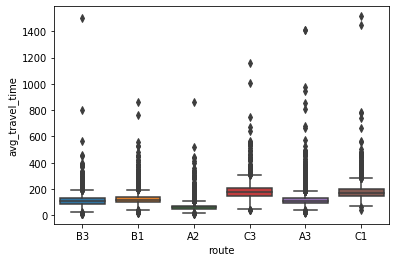

In [21]:
sns.boxplot(x='route', y='avg_travel_time', data=train_table1);

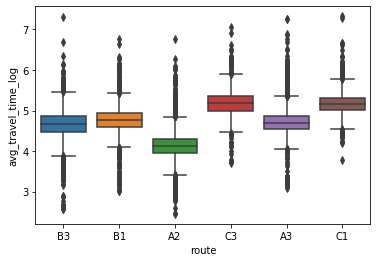

In [22]:
sns.boxplot(x='route', y='avg_travel_time_log', data=train_table1);

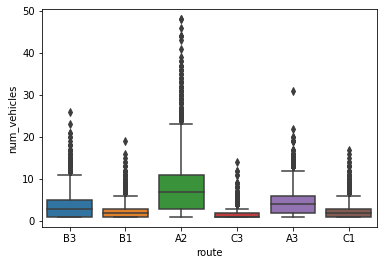

In [23]:
sns.boxplot(x='route', y='num_vehicles', data=train_table1);

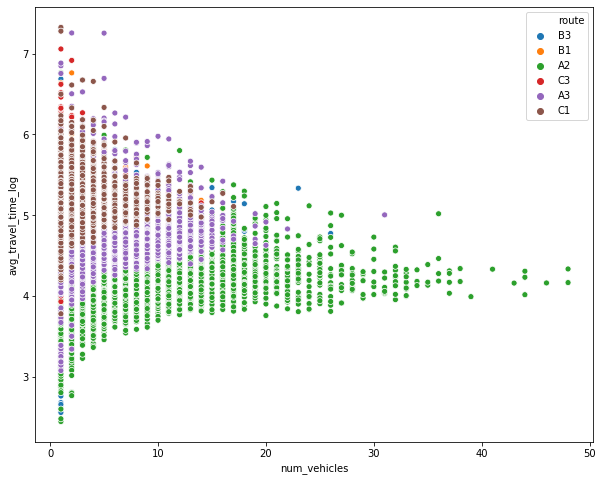

In [24]:
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x='num_vehicles', y='avg_travel_time_log', hue='route', data=train_table1, ax=ax);

#### New field: num_vehicles_proportion

In [25]:
# calculate highest no. of vehicles along each route per time window
def max_vehicles(data, route):
    df = data[data['route']==route]
    max_veh = df['num_vehicles'].max()
    return max_veh

In [26]:
# calculate highest no. of vehicles along route A2 per time window
max_veh_a2 = max_vehicles(train_table1, 'A2')
max_veh_a2

48.0

In [27]:
# calculate highest no. of vehicles along route A3 per time window
max_veh_a3 = max_vehicles(train_table1, 'A3')
max_veh_a3

31.0

In [28]:
# calculate highest no. of vehicles along route B1 per time window
max_veh_b1 = max_vehicles(train_table1, 'B1')
max_veh_b1

19.0

In [29]:
# calculate highest no. of vehicles along route B3 per time window
max_veh_b3 = max_vehicles(train_table1, 'B3')
max_veh_b3

26.0

In [30]:
# calculate highest no. of vehicles along route C1 per time window
max_veh_c1 = max_vehicles(train_table1, 'C1')
max_veh_c1

17.0

In [31]:
# calculate highest no. of vehicles along route C3 per time window
max_veh_c3 = max_vehicles(train_table1, 'C3')
max_veh_c3

14.0

In [32]:
# calculate num_vehicles / max_veh per route
def num_veh_p(num_veh, route):
    proportion = num_veh / max_vehicles(train_table1, route) 
    return proportion

In [33]:
train_table1['num_vehicles_proportion'] = train_table1.apply(lambda x: num_veh_p(x['num_vehicles'], x['route']), axis=1)

In [34]:
train_table1.head()

,intersection_id,tollgate_id,time_window,avg_travel_time,num_vehicles,route,avg_travel_time_log,num_vehicles_proportion
0,B,3,"[2016-07-19 00:00:00,2016-07-19 00:20:00)",70.85,1.0,B3,4.274581,0.038462
1,B,3,"[2016-07-19 00:20:00,2016-07-19 00:40:00)",148.79,1.0,B3,5.009234,0.038462
2,B,3,"[2016-07-19 01:40:00,2016-07-19 02:00:00)",93.72,2.0,B3,4.550925,0.076923
3,B,3,"[2016-07-19 02:00:00,2016-07-19 02:20:00)",67.81,1.0,B3,4.231349,0.038462
4,B,3,"[2016-07-19 02:40:00,2016-07-19 03:00:00)",167.55,2.0,B3,5.127232,0.076923


#### New field: start_datetime

In [35]:
# extract string between '[' and ','
train_table1['start_datetime'] = train_table1['time_window'].apply(lambda x: x[x.find('[')+1 : x.find(',', x.find('[')+1)])

In [36]:
train_table1.head()

,intersection_id,tollgate_id,time_window,avg_travel_time,num_vehicles,route,avg_travel_time_log,num_vehicles_proportion,start_datetime
0,B,3,"[2016-07-19 00:00:00,2016-07-19 00:20:00)",70.85,1.0,B3,4.274581,0.038462,2016-07-19 00:00:00
1,B,3,"[2016-07-19 00:20:00,2016-07-19 00:40:00)",148.79,1.0,B3,5.009234,0.038462,2016-07-19 00:20:00
2,B,3,"[2016-07-19 01:40:00,2016-07-19 02:00:00)",93.72,2.0,B3,4.550925,0.076923,2016-07-19 01:40:00
3,B,3,"[2016-07-19 02:00:00,2016-07-19 02:20:00)",67.81,1.0,B3,4.231349,0.038462,2016-07-19 02:00:00
4,B,3,"[2016-07-19 02:40:00,2016-07-19 03:00:00)",167.55,2.0,B3,5.127232,0.076923,2016-07-19 02:40:00


In [37]:
# check column data type
train_table1.dtypes

intersection_id             object
tollgate_id                 object
time_window                 object
avg_travel_time            float64
num_vehicles               float64
route                       object
avg_travel_time_log        float64
num_vehicles_proportion    float64
start_datetime              object
dtype: object

In [38]:
# convert start_datetime to datetime object
train_table1['start_datetime'] = pd.to_datetime(train_table1['start_datetime'])

In [39]:
# check column data type
train_table1.dtypes

intersection_id                    object
tollgate_id                        object
time_window                        object
avg_travel_time                   float64
num_vehicles                      float64
route                              object
avg_travel_time_log               float64
num_vehicles_proportion           float64
start_datetime             datetime64[ns]
dtype: object

#### New field: start_hour

In [40]:
train_table1['start_hour'] = train_table1['start_datetime'].dt.hour
train_table1['start_hour'].value_counts()

13    1396
14    1389
12    1380
9     1349
16    1344
15    1340
8     1336
11    1314
10    1310
17    1268
7     1264
18    1209
19    1157
20    1109
6     1084
21    1069
22     900
5      727
23     709
0      605
4      545
1      477
3      447
2      416
Name: start_hour, dtype: int64

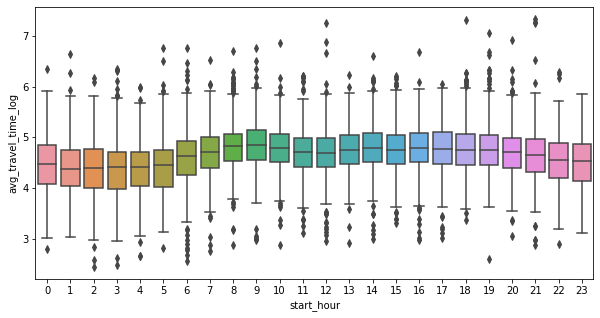

In [41]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='start_hour', y='avg_travel_time_log', data=train_table1, ax=ax);

#### New field: day_of_week

In [42]:
train_table1['day_of_week'] = train_table1['start_datetime'].dt.weekday
train_table1['day_of_week'].value_counts()

5    3675
4    3672
2    3622
3    3610
6    3540
1    3525
0    3500
Name: day_of_week, dtype: int64

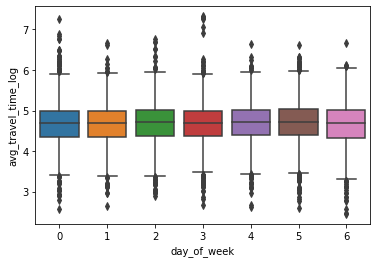

In [43]:
sns.boxplot(x='day_of_week', y='avg_travel_time_log', data=train_table1);

#### New field: weekday

In [44]:
wkday = [0,1,2,3,4]
train_table1['weekday'] = np.where(train_table1['day_of_week'].isin(wkday),1,0)
train_table1['weekday'].value_counts()

1    17929
0     7215
Name: weekday, dtype: int64

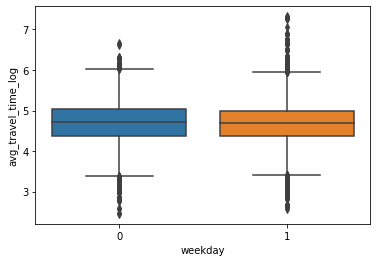

In [45]:
sns.boxplot(x='weekday', y='avg_travel_time_log', data=train_table1);

#### New field: day_of_year

In [46]:
train_table1['day_of_year'] = train_table1['start_datetime'].dt.dayofyear

#### New field: holiday

In [47]:
# assume dataset is in the context of china
# list out holidays between July to Oct
china_holidays_str = ['2016-09-15','2016-09-16','2016-09-17',
                      '2016-10-01','2016-10-02','2016-10-03',
                      '2016-10-04','2016-10-05','2016-10-06','2016-10-07']

china_holidays = []
for i in range(len(china_holidays_str)):
    china_holidays.append(datetime.strptime(china_holidays_str[i], "%Y-%m-%d"))

In [48]:
train_table1['holiday'] = np.where(train_table1['start_datetime'].isin(china_holidays),1,0)
train_table1['holiday'].value_counts()

0    25113
1       31
Name: holiday, dtype: int64

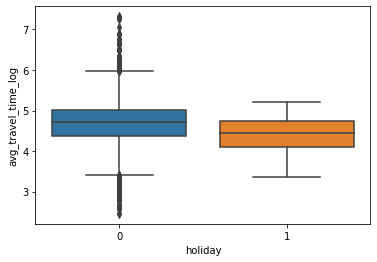

In [49]:
sns.boxplot(x='holiday', y='avg_travel_time_log', data=train_table1);

#### New field: rush_hour

In [50]:
# Satisfy the following conditions: rush_hr = [8,9,17,18], wkday = [0,1,2,3,4], hol = [0]
# True & True & True = True; and False & False & False = False
# by right, rush hour should not occur on weekends / hols, although the prediction applies "rush hour" to all days of the week
rush_hr = [8,9,17,18]
wkday = [0,1,2,3,4]
hol = [0]
train_table1['rush_hour'] = np.where(train_table1['start_hour'].isin(rush_hr) & train_table1['weekday'].isin(wkday) & train_table1['holiday'].isin(hol),1,0)
train_table1['rush_hour'].value_counts()

0    19982
1     5162
Name: rush_hour, dtype: int64

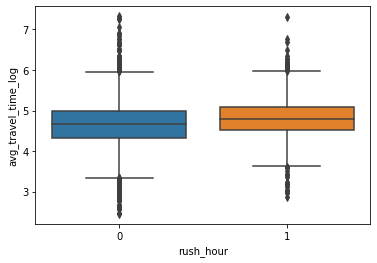

In [51]:
sns.boxplot(x='rush_hour', y='avg_travel_time_log', data=train_table1);

#### New field: hour_of_day

In [52]:
interval_range1 = pd.interval_range(start=0, freq=2, end=24, closed='left')
interval_range1

IntervalIndex([[0, 2), [2, 4), [4, 6), [6, 8), [8, 10) ... [14, 16), [16, 18), [18, 20), [20, 22), [22, 24)],
              closed='left',
              dtype='interval[int64]')

In [53]:
train_table1['hour_of_day1'] = pd.cut(train_table1['start_hour'], bins=interval_range1)
train_table1['hour_of_day1'].value_counts()

[12, 14)    2776
[14, 16)    2729
[8, 10)     2685
[10, 12)    2624
[16, 18)    2612
[18, 20)    2366
[6, 8)      2348
[20, 22)    2178
[22, 24)    1609
[4, 6)      1272
[0, 2)      1082
[2, 4)       863
Name: hour_of_day1, dtype: int64

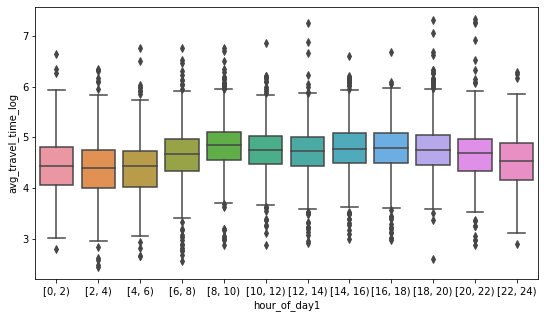

In [54]:
fig, ax = plt.subplots(figsize=(9,5))
sns.boxplot(x='hour_of_day1', y='avg_travel_time_log', data=train_table1);

In [55]:
interval_range2 = pd.interval_range(start=0, freq=4, end=24, closed='left')
interval_range2

IntervalIndex([[0, 4), [4, 8), [8, 12), [12, 16), [16, 20), [20, 24)],
              closed='left',
              dtype='interval[int64]')

In [56]:
train_table1['hour_of_day2'] = pd.cut(train_table1['start_hour'], bins=interval_range2)
train_table1['hour_of_day2'].value_counts()

[12, 16)    5505
[8, 12)     5309
[16, 20)    4978
[20, 24)    3787
[4, 8)      3620
[0, 4)      1945
Name: hour_of_day2, dtype: int64

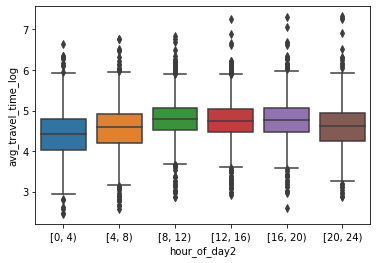

In [57]:
sns.boxplot(x='hour_of_day2', y='avg_travel_time_log', data=train_table1);

In [58]:
interval_range3 = pd.interval_range(start=0, freq=6, end=24, closed='left')
interval_range3

IntervalIndex([[0, 6), [6, 12), [12, 18), [18, 24)],
              closed='left',
              dtype='interval[int64]')

In [59]:
train_table1['hour_of_day3'] = pd.cut(train_table1['start_hour'], bins=interval_range3)
train_table1['hour_of_day3'].value_counts()

[12, 18)    8117
[6, 12)     7657
[18, 24)    6153
[0, 6)      3217
Name: hour_of_day3, dtype: int64

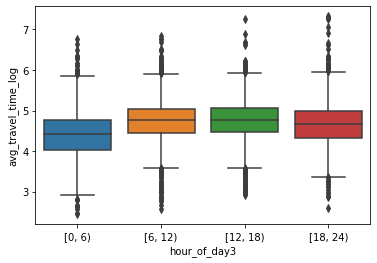

In [60]:
sns.boxplot(x='hour_of_day3', y='avg_travel_time_log', data=train_table1);

#### New field: start_datetime_decimal -> Express "day", "hour", "min" as a fraction of a year

In [61]:
# day_of_year - 1 / 366; "-1" is because 2016-01-01 = (1-1)/366 = 0, vs 1/366 = 0.0027; "366" is because 2016 is leap yr
# took some inspiration from here: https://stackoverflow.com/questions/6451655/how-to-convert-python-datetime-dates-to-decimal-float-years
#train_table1['start_datetime_decimal1'] = train_table1['start_datetime'].apply(lambda x: ((float(x.strftime("%j"))-1)/366) + ((float(x.strftime("%H"))/24)/366) + (((float(x.strftime("%M"))/60)/24)/366))
#train_table1['start_datetime_decimal1']

#### New field: start_datetime_decimal -> Express "day", "hour", "min" as a fraction of a day of year

In [62]:
# day_of_year - 1 / 366; "-1" is because 2016-01-01 = (1-1)/366 = 0, vs 1/366 = 0.0027; "366" is because 2016 is leap yr
train_table1['start_datetime_decimal'] = train_table1['start_datetime'].apply(lambda x: float(x.strftime("%j")) + (float(x.strftime("%H"))/24) + ((float(x.strftime("%M"))/60)/24))
train_table1['start_datetime_decimal']

0        201.000000
1        201.013889
2        201.069444
3        201.083333
4        201.111111
            ...    
25139    291.861111
25140    291.888889
25141    291.930556
25142    291.958333
25143    291.972222
Name: start_datetime_decimal, Length: 25144, dtype: float64

In [63]:
train_table1.head()

,intersection_id,tollgate_id,time_window,avg_travel_time,num_vehicles,route,avg_travel_time_log,num_vehicles_proportion,start_datetime,start_hour,day_of_week,weekday,day_of_year,holiday,rush_hour,hour_of_day1,hour_of_day2,hour_of_day3,start_datetime_decimal
0,B,3,"[2016-07-19 00:00:00,2016-07-19 00:20:00)",70.85,1.0,B3,4.274581,0.038462,2016-07-19 00:00:00,0,1,1,201,0,0,"[0, 2)","[0, 4)","[0, 6)",201.000000
1,B,3,"[2016-07-19 00:20:00,2016-07-19 00:40:00)",148.79,1.0,B3,5.009234,0.038462,2016-07-19 00:20:00,0,1,1,201,0,0,"[0, 2)","[0, 4)","[0, 6)",201.013889
2,B,3,"[2016-07-19 01:40:00,2016-07-19 02:00:00)",93.72,2.0,B3,4.550925,0.076923,2016-07-19 01:40:00,1,1,1,201,0,0,"[0, 2)","[0, 4)","[0, 6)",201.069444
3,B,3,"[2016-07-19 02:00:00,2016-07-19 02:20:00)",67.81,1.0,B3,4.231349,0.038462,2016-07-19 02:00:00,2,1,1,201,0,0,"[2, 4)","[0, 4)","[0, 6)",201.083333
4,B,3,"[2016-07-19 02:40:00,2016-07-19 03:00:00)",167.55,2.0,B3,5.127232,0.076923,2016-07-19 02:40:00,2,1,1,201,0,0,"[2, 4)","[0, 4)","[0, 6)",201.111111


In [64]:
train_table1.tail()

,intersection_id,tollgate_id,time_window,avg_travel_time,num_vehicles,route,avg_travel_time_log,num_vehicles_proportion,start_datetime,start_hour,day_of_week,weekday,day_of_year,holiday,rush_hour,hour_of_day1,hour_of_day2,hour_of_day3,start_datetime_decimal
25139,C,1,"[2016-10-17 20:40:00,2016-10-17 21:00:00)",171.97,1.0,C1,5.153118,0.058824,2016-10-17 20:40:00,20,0,1,291,0,0,"[20, 22)","[20, 24)","[18, 24)",291.861111
25140,C,1,"[2016-10-17 21:20:00,2016-10-17 21:40:00)",121.61,1.0,C1,4.809009,0.058824,2016-10-17 21:20:00,21,0,1,291,0,0,"[20, 22)","[20, 24)","[18, 24)",291.888889
25141,C,1,"[2016-10-17 22:20:00,2016-10-17 22:40:00)",115.16,2.0,C1,4.754969,0.117647,2016-10-17 22:20:00,22,0,1,291,0,0,"[22, 24)","[20, 24)","[18, 24)",291.930556
25142,C,1,"[2016-10-17 23:00:00,2016-10-17 23:20:00)",194.33,1.0,C1,5.274690,0.058824,2016-10-17 23:00:00,23,0,1,291,0,0,"[22, 24)","[20, 24)","[18, 24)",291.958333
25143,C,1,"[2016-10-17 23:20:00,2016-10-17 23:40:00)",159.78,1.0,C1,5.080037,0.058824,2016-10-17 23:20:00,23,0,1,291,0,0,"[22, 24)","[20, 24)","[18, 24)",291.972222


In [65]:
train_table1.shape

(25144, 19)

### Table7 (weather): Join to table1

In [66]:
train_table1.head(1)

,intersection_id,tollgate_id,time_window,avg_travel_time,num_vehicles,route,avg_travel_time_log,num_vehicles_proportion,start_datetime,start_hour,day_of_week,weekday,day_of_year,holiday,rush_hour,hour_of_day1,hour_of_day2,hour_of_day3,start_datetime_decimal
0,B,3,"[2016-07-19 00:00:00,2016-07-19 00:20:00)",70.85,1.0,B3,4.274581,0.038462,2016-07-19,0,1,1,201,0,0,"[0, 2)","[0, 4)","[0, 6)",201.0


In [67]:
train_table1.dtypes

intersection_id                    object
tollgate_id                        object
time_window                        object
avg_travel_time                   float64
num_vehicles                      float64
route                              object
avg_travel_time_log               float64
num_vehicles_proportion           float64
start_datetime             datetime64[ns]
start_hour                          int64
day_of_week                         int64
weekday                             int32
day_of_year                         int64
holiday                             int32
rush_hour                           int32
hour_of_day1                     category
hour_of_day2                     category
hour_of_day3                     category
start_datetime_decimal            float64
dtype: object

In [68]:
train_table7.head(1)

,date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
0,2016-07-01,0,1000.4,1005.3,225.0,2.1,26.4,94.0,0.0


In [69]:
train_table7.dtypes

date               object
hour                int64
pressure          float64
sea_pressure      float64
wind_direction    float64
wind_speed        float64
temperature       float64
rel_humidity      float64
precipitation     float64
dtype: object

In [70]:
train_table7['hour']

0       0
1       3
2       6
3       9
4      12
5      15
6      18
7      21
8       0
9       3
10      6
11      9
12     12
13     15
14     18
15     21
16      0
17      3
18      6
19      9
20     12
21     15
22     18
23     21
24      0
25      3
26      6
27      9
28     12
29     15
30     18
31     21
32      0
33      3
34      6
35      9
36     12
37     15
38     18
39     21
40      0
41      3
42      6
43      9
44     12
45     15
46     18
47     21
48      0
49      3
50      6
51      9
52     12
53     15
54     18
55     21
56      0
57      3
58      6
59      9
60     12
61     15
62     18
63     21
64      0
65      3
66      6
67      9
68     12
69     15
70     18
71     21
72      0
73      3
74      6
75      9
76     12
77     15
78     18
79     21
80      0
81      3
82      6
83      9
84     12
85     15
86     18
87     21
88      0
89      3
90      6
91      9
92     12
93     15
94     18
95     21
96      0
97      3
98      6
99      9


In [71]:
# convert hour into str
train_table7['hour'] = train_table7['hour'].astype('str')

In [72]:
# combine date (str) + hour (str) into datetime (str)
# combine date+time into 1 field because asof merge cannot perform on multiple keys
train_table7['datetime'] = train_table7['date'] + ' ' + train_table7['hour']

In [73]:
train_table7['datetime']

0       2016-07-01 0
1       2016-07-01 3
2       2016-07-01 6
3       2016-07-01 9
4      2016-07-01 12
5      2016-07-01 15
6      2016-07-01 18
7      2016-07-01 21
8       2016-07-02 0
9       2016-07-02 3
10      2016-07-02 6
11      2016-07-02 9
12     2016-07-02 12
13     2016-07-02 15
14     2016-07-02 18
15     2016-07-02 21
16      2016-07-03 0
17      2016-07-03 3
18      2016-07-03 6
19      2016-07-03 9
20     2016-07-03 12
21     2016-07-03 15
22     2016-07-03 18
23     2016-07-03 21
24      2016-07-04 0
25      2016-07-04 3
26      2016-07-04 6
27      2016-07-04 9
28     2016-07-04 12
29     2016-07-04 15
30     2016-07-04 18
31     2016-07-04 21
32      2016-07-05 0
33      2016-07-05 3
34      2016-07-05 6
35      2016-07-05 9
36     2016-07-05 12
37     2016-07-05 15
38     2016-07-05 18
39     2016-07-05 21
40      2016-07-06 0
41      2016-07-06 3
42      2016-07-06 6
43      2016-07-06 9
44     2016-07-06 12
45     2016-07-06 15
46     2016-07-06 18
47     2016-0

In [74]:
# convert datetime (str) into datetime object (note: format is not this '%Y-%m-%d %H:%M:%S')
train_table7['datetime'] = train_table7['datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H'))

In [75]:
train_table7['datetime']

0     2016-07-01 00:00:00
1     2016-07-01 03:00:00
2     2016-07-01 06:00:00
3     2016-07-01 09:00:00
4     2016-07-01 12:00:00
5     2016-07-01 15:00:00
6     2016-07-01 18:00:00
7     2016-07-01 21:00:00
8     2016-07-02 00:00:00
9     2016-07-02 03:00:00
10    2016-07-02 06:00:00
11    2016-07-02 09:00:00
12    2016-07-02 12:00:00
13    2016-07-02 15:00:00
14    2016-07-02 18:00:00
15    2016-07-02 21:00:00
16    2016-07-03 00:00:00
17    2016-07-03 03:00:00
18    2016-07-03 06:00:00
19    2016-07-03 09:00:00
20    2016-07-03 12:00:00
21    2016-07-03 15:00:00
22    2016-07-03 18:00:00
23    2016-07-03 21:00:00
24    2016-07-04 00:00:00
25    2016-07-04 03:00:00
26    2016-07-04 06:00:00
27    2016-07-04 09:00:00
28    2016-07-04 12:00:00
29    2016-07-04 15:00:00
30    2016-07-04 18:00:00
31    2016-07-04 21:00:00
32    2016-07-05 00:00:00
33    2016-07-05 03:00:00
34    2016-07-05 06:00:00
35    2016-07-05 09:00:00
36    2016-07-05 12:00:00
37    2016-07-05 15:00:00
38    2016-0

In [76]:
train_table7.head()

,date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,datetime
0,2016-07-01,0,1000.4,1005.3,225.0,2.1,26.4,94.0,0.0,2016-07-01 00:00:00
1,2016-07-01,3,1000.5,1005.3,187.0,2.7,29.0,76.0,0.0,2016-07-01 03:00:00
2,2016-07-01,6,998.9,1003.7,212.0,2.9,31.7,67.0,0.0,2016-07-01 06:00:00
3,2016-07-01,9,998.7,1003.5,244.0,2.7,31.6,59.0,0.0,2016-07-01 09:00:00
4,2016-07-01,12,999.7,1004.5,222.0,1.3,29.9,68.0,0.0,2016-07-01 12:00:00


In [77]:
# sort
train_table1.sort_values(by=['start_datetime'], inplace=True)

In [78]:
# sort
train_table7.sort_values(by=['datetime'], inplace=True)

In [79]:
# pandas asof merge: similar to a left-join except that we match on nearest key rather than equal keys.
# Both DataFrames must be sorted by the key.
# allow_exact_matches: bool, default True
# direction: ‘backward’ (default), ‘forward’, or ‘nearest’

# train_table1['start_datetime'] is at every 20min interval, whereas train_table7['datetime'] is at 3-hourly interval
# train_table1['start_datetime']: 0h, 1h, 2h -> map to train_table7['datetime']: 0h
# train_table1['start_datetime']: 3h, 4h, 5h -> map to train_table7['datetime']: 3h 
# this assumes that the weather within every 3hourly interval remains the same.

train = pd.merge_asof(train_table1, 
                      train_table7, 
                      left_on=['start_datetime'], 
                      right_on=['datetime'])

In [80]:
train.shape

(25144, 29)

In [81]:
train.head()

,intersection_id,tollgate_id,time_window,avg_travel_time,num_vehicles,route,avg_travel_time_log,num_vehicles_proportion,start_datetime,start_hour,day_of_week,weekday,day_of_year,holiday,rush_hour,hour_of_day1,hour_of_day2,hour_of_day3,start_datetime_decimal,date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,datetime
0,B,3,"[2016-07-19 00:00:00,2016-07-19 00:20:00)",70.85,1.0,B3,4.274581,0.038462,2016-07-19 00:00:00,0,1,1,201,0,0,"[0, 2)","[0, 4)","[0, 6)",201.000000,2016-07-19,0,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0,2016-07-19
1,B,3,"[2016-07-19 00:20:00,2016-07-19 00:40:00)",148.79,1.0,B3,5.009234,0.038462,2016-07-19 00:20:00,0,1,1,201,0,0,"[0, 2)","[0, 4)","[0, 6)",201.013889,2016-07-19,0,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0,2016-07-19
2,B,1,"[2016-07-19 00:20:00,2016-07-19 00:40:00)",79.76,1.0,B1,4.391482,0.052632,2016-07-19 00:20:00,0,1,1,201,0,0,"[0, 2)","[0, 4)","[0, 6)",201.013889,2016-07-19,0,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0,2016-07-19
3,A,2,"[2016-07-19 00:20:00,2016-07-19 00:40:00)",58.05,1.0,A2,4.078385,0.020833,2016-07-19 00:20:00,0,1,1,201,0,0,"[0, 2)","[0, 4)","[0, 6)",201.013889,2016-07-19,0,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0,2016-07-19
4,C,3,"[2016-07-19 00:40:00,2016-07-19 01:00:00)",113.54,1.0,C3,4.740924,0.071429,2016-07-19 00:40:00,0,1,1,201,0,0,"[0, 2)","[0, 4)","[0, 6)",201.027778,2016-07-19,0,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0,2016-07-19


### Data Manipulation - Tidy Up Columns

In [82]:
train.dtypes

intersection_id                    object
tollgate_id                        object
time_window                        object
avg_travel_time                   float64
num_vehicles                      float64
route                              object
avg_travel_time_log               float64
num_vehicles_proportion           float64
start_datetime             datetime64[ns]
start_hour                          int64
day_of_week                         int64
weekday                             int32
day_of_year                         int64
holiday                             int32
rush_hour                           int32
hour_of_day1                     category
hour_of_day2                     category
hour_of_day3                     category
start_datetime_decimal            float64
date                               object
hour                               object
pressure                          float64
sea_pressure                      float64
wind_direction                    

C:\Users\User\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning:

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.



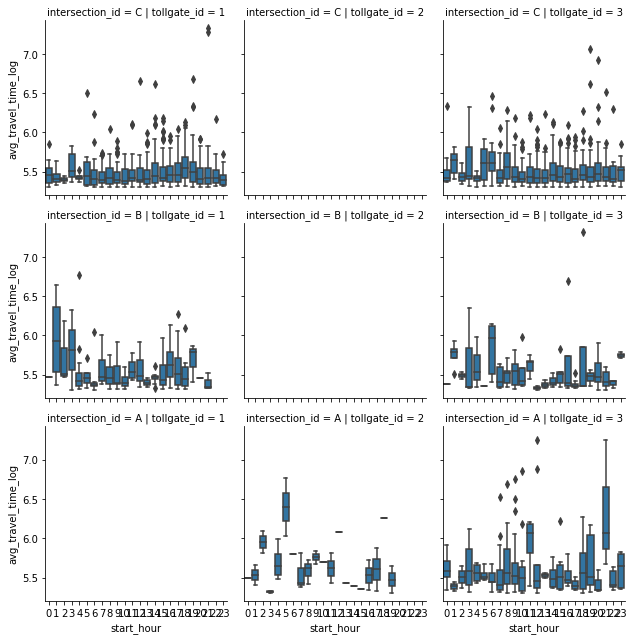

In [83]:
data = train[(train['avg_travel_time']>=200)]
g = sns.FacetGrid(data, row='intersection_id', col='tollgate_id')
g.map(sns.boxplot, 'start_hour', 'avg_travel_time_log');

In [84]:
# drop columns
train1 = train.drop(['avg_travel_time_log',
                     'start_hour',
                     'day_of_year', 
                     'hour_of_day1',
                     'hour_of_day3',
                     'date',
                     'hour',
                     'datetime'], axis=1)

In [85]:
train1.dtypes

intersection_id                    object
tollgate_id                        object
time_window                        object
avg_travel_time                   float64
num_vehicles                      float64
route                              object
num_vehicles_proportion           float64
start_datetime             datetime64[ns]
day_of_week                         int64
weekday                             int32
holiday                             int32
rush_hour                           int32
hour_of_day2                     category
start_datetime_decimal            float64
pressure                          float64
sea_pressure                      float64
wind_direction                    float64
wind_speed                        float64
temperature                       float64
rel_humidity                      float64
precipitation                     float64
dtype: object

In [86]:
train1.shape

(25144, 21)

### One Hot Encoding

In [87]:
train2 = pd.get_dummies(train1, columns=['hour_of_day2'])

In [88]:
train2.shape

(25144, 26)

In [89]:
train2.dtypes

intersection_id                    object
tollgate_id                        object
time_window                        object
avg_travel_time                   float64
num_vehicles                      float64
route                              object
num_vehicles_proportion           float64
start_datetime             datetime64[ns]
day_of_week                         int64
weekday                             int32
holiday                             int32
rush_hour                           int32
start_datetime_decimal            float64
pressure                          float64
sea_pressure                      float64
wind_direction                    float64
wind_speed                        float64
temperature                       float64
rel_humidity                      float64
precipitation                     float64
hour_of_day2_[0, 4)                 uint8
hour_of_day2_[4, 8)                 uint8
hour_of_day2_[8, 12)                uint8
hour_of_day2_[12, 16)             

### Evaluation Metric

In [90]:
# Formula from https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

### Define function to derive train/test df for each route

In [152]:
# Define function to derive train/val/test df for each route

def df_route(df, route):
    
    # filter df by route
    df1 = df[df['route']==route]

    # assign datetimeindex for resampling
    df1.index = df1['start_datetime'] 

    # resample to generate datetimeindex at every 20min intervals (20T = 20min)
    df2 = df1.resample('20T').first()
    
    # shift datetime for the new index at t+6
    df2['start_datetime_+6'] = df2['start_datetime'].shift(-6, freq='20T')

    # create new target column that holds the avg time exactly 2h (t+6) later
    df2['avg_travel_time_+1'] = df2['avg_travel_time'].shift(-1, freq='20T')
    df2['avg_travel_time_+2'] = df2['avg_travel_time'].shift(-2, freq='20T')
    df2['avg_travel_time_+3'] = df2['avg_travel_time'].shift(-3, freq='20T')
    df2['avg_travel_time_+4'] = df2['avg_travel_time'].shift(-4, freq='20T')
    df2['avg_travel_time_+5'] = df2['avg_travel_time'].shift(-5, freq='20T')
    df2['avg_travel_time_+6'] = df2['avg_travel_time'].shift(-6, freq='20T')

    # drop rows corresponding to 'avg_travel_time_+6' with null values
    #df3 = df2.dropna()
    df3 = df2.drop(df2[df2['avg_travel_time_+6'].isna()].index)

    # re-index df with datetime+6 to match target+6 column
    df3.index = df3['start_datetime_+6']

    # drop columns that will not be used for prediction
    df4 = df3.drop(['intersection_id', 
                    'tollgate_id', 
                    'time_window', 
                    'start_datetime', 
                    'start_datetime_+6', 
                    'route'], axis=1)
    
    # split train/test
    train = df4[datetime(2016,7,19,0,0,0):datetime(2016,9,26,23,40,0)]
    print(train.shape)
    
    val = df4[datetime(2016,9,27,0,0,0):datetime(2016,10,10,23,40,0)]
    print(val.shape)

    test = df4[datetime(2016,10,11,0,0,0):datetime(2016,10,17,23,40,0)]
    print(test.shape)
    
    # separate into xtrain, ytrain
    ytrain = train['avg_travel_time_+6']
    xtrain = train.drop(['avg_travel_time_+6'], axis=1)

    yval= val['avg_travel_time_+6']
    xval = val.drop(['avg_travel_time_+6'], axis=1)
    
    ytest = test['avg_travel_time_+6']
    xtest = test.drop(['avg_travel_time_+6'], axis=1)

    xtrain_columns = xtrain.columns
    print(xtrain_columns)
    
    ytrain_index = ytrain.index
    
    yval_index = yval.index
    
    ytest_index = ytest.index

    # normalize variables
    scaler = MinMaxScaler()

    xtrain = scaler.fit_transform(xtrain)
    
    xval = scaler.transform(xval)
    xtest = scaler.transform(xtest)

    return xtrain, ytrain, xval, yval, xtest, ytest, xtrain_columns, ytrain_index, yval_index, ytest_index

### A2

In [153]:
A2_xtrain, A2_ytrain, A2_xval, A2_yval, A2_xtest, A2_ytest, A2_xtrain_columns, A2_ytrain_index, A2_yval_index, A2_ytest_index = df_route(train2, 'A2')

(4539, 27)
(952, 27)
(471, 27)
Index(['avg_travel_time', 'num_vehicles', 'num_vehicles_proportion',
       'day_of_week', 'weekday', 'holiday', 'rush_hour',
       'start_datetime_decimal', 'pressure', 'sea_pressure', 'wind_direction',
       'wind_speed', 'temperature', 'rel_humidity', 'precipitation',
       'hour_of_day2_[0, 4)', 'hour_of_day2_[4, 8)', 'hour_of_day2_[8, 12)',
       'hour_of_day2_[12, 16)', 'hour_of_day2_[16, 20)',
       'hour_of_day2_[20, 24)', 'avg_travel_time_+1', 'avg_travel_time_+2',
       'avg_travel_time_+3', 'avg_travel_time_+4', 'avg_travel_time_+5'],
      dtype='object')


#### XGBoost

In [154]:
%%time

# XGBoost
xgb = XGBRegressor(objective ='reg:squarederror', random_state=2020)

param_dist= {"n_estimators": randint(80,200), # no. of trees to build
             "learning_rate": uniform(0.01,0.2), # learning rate; step size shrinkage to prevent overfitting
             "max_depth": randint(10,150), # how deep each tree can grow
             "subsample": uniform(0.5,1), # range: (0,1], % samples used per tree; low value -> underfitting
             "colsample_bytree": uniform(0.5,1)} # range: (0,1], % samples used per tree; High value -> overfitting

# use RandomizedSearchCV for faster and effective performance
rs_xgb = RandomizedSearchCV(xgb, 
                            param_distributions=param_dist, 
                            n_iter=20,
                            scoring='neg_mean_squared_error',
                            cv=5,
                            n_jobs=-1, 
                            random_state=2020)

rs_xgb.fit(A2_xtrain, A2_ytrain)

# best params
print('Best Parameters: \n', rs_xgb.best_params_)

# Training MSE
print('Training MSE: ', abs(rs_xgb.best_score_))

Best Parameters: 
 {'colsample_bytree': 0.5200447598411051, 'learning_rate': 0.09243289041479898, 'max_depth': 100, 'n_estimators': 86, 'subsample': 0.8550562049251555}
Training MSE:  1128.396656969526
Wall time: 1min 8s


In [155]:
# XGBoost
# extract feature importances
feature_importances = pd.DataFrame(rs_xgb.best_estimator_.feature_importances_,
                                   index = A2_xtrain_columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
"hour_of_day2_[4, 8)",0.122973
avg_travel_time_+5,0.102063
avg_travel_time_+1,0.098207
"hour_of_day2_[20, 24)",0.075895
avg_travel_time_+2,0.062108


In [156]:
# XGBoost 
# best model from ensemble learning
best_xgb = rs_xgb.best_estimator_

# predict on validation set
A2_ypred_val_xgb = best_xgb.predict(A2_xval)

# Validation MSE
mse = mean_squared_error(A2_yval, A2_ypred_val_xgb)
print('Validation MSE: ', mse)

Validation MSE:  493.14422071397763


In [157]:
# XGBoost
# Validation MAPE
A2_yval_mape = MAPE(A2_yval, A2_ypred_val_xgb)
print('Validation MAPE:', A2_yval_mape)

Validation MAPE: 0.25093264699131607


In [158]:
# XGBoost 
# predict on test set
A2_ypred_test_xgb = best_xgb.predict(A2_xtest)

# Test MSE
mse = mean_squared_error(A2_ytest, A2_ypred_test_xgb)
print('Test MSE: ', mse)

# Test MAPE
A2_ytest_mape = MAPE(A2_ytest, A2_ypred_test_xgb)
print('Test MAPE:', A2_ytest_mape)

Test MSE:  615.3624566111499
Test MAPE: 0.23481697735031876


In [159]:
# convert prediction array to df
A2_ypred_val_xgb1 = pd.DataFrame(A2_ypred_val_xgb)
A2_ypred_val_xgb1.index = A2_yval_index

In [160]:
# convert true validation array to df
A2_yval1 = pd.DataFrame(A2_yval)
A2_yval1.index = A2_yval_index

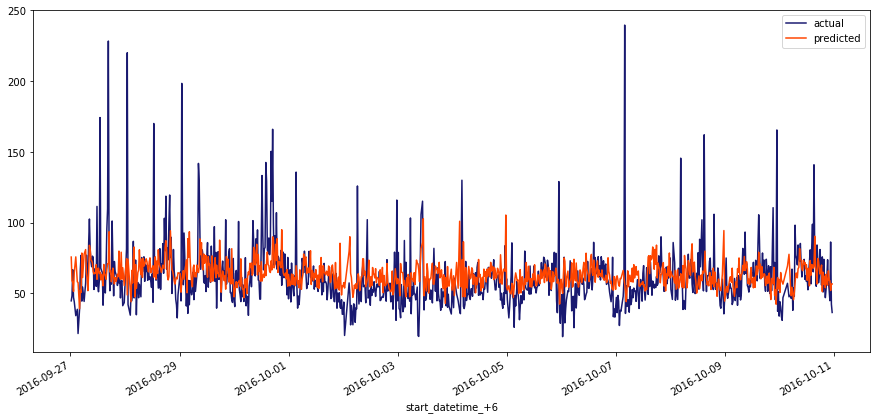

In [161]:
# base plot of true values
fig, ax = plt.subplots(figsize=(15,7))
base = A2_yval1.plot(ax=ax, color='midnightblue')

# overlay predicted values in red
A2_ypred_val_xgb1.plot(ax=base, color='orangered')

plt.legend(labels=['actual','predicted']);

### A3

In [162]:
A3_xtrain, A3_ytrain, A3_xval, A3_yval, A3_xtest, A3_ytest, A3_xtrain_columns, A3_ytrain_index, A3_yval_index, A3_ytest_index = df_route(train2, 'A3')

(3995, 27)
(879, 27)
(427, 27)
Index(['avg_travel_time', 'num_vehicles', 'num_vehicles_proportion',
       'day_of_week', 'weekday', 'holiday', 'rush_hour',
       'start_datetime_decimal', 'pressure', 'sea_pressure', 'wind_direction',
       'wind_speed', 'temperature', 'rel_humidity', 'precipitation',
       'hour_of_day2_[0, 4)', 'hour_of_day2_[4, 8)', 'hour_of_day2_[8, 12)',
       'hour_of_day2_[12, 16)', 'hour_of_day2_[16, 20)',
       'hour_of_day2_[20, 24)', 'avg_travel_time_+1', 'avg_travel_time_+2',
       'avg_travel_time_+3', 'avg_travel_time_+4', 'avg_travel_time_+5'],
      dtype='object')


#### XGBoost

In [163]:
%%time

# XGBoost
xgb = XGBRegressor(objective ='reg:squarederror', random_state=2020)

param_dist= {"n_estimators": randint(80,200), # no. of trees to build
             "learning_rate": uniform(0.01,0.2), # learning rate; step size shrinkage to prevent overfitting
             "max_depth": randint(10,150), # how deep each tree can grow
             "subsample": uniform(0.5,1), # range: (0,1], % samples used per tree; low value -> underfitting
             "colsample_bytree": uniform(0.5,1)} # range: (0,1], % samples used per tree; High value -> overfitting

# use RandomizedSearchCV for faster and effective performance
rs_xgb = RandomizedSearchCV(xgb, 
                            param_distributions=param_dist, 
                            n_iter=20,
                            scoring='neg_mean_squared_error',
                            cv=5,
                            n_jobs=-1, 
                            random_state=2020)

rs_xgb.fit(A3_xtrain, A3_ytrain)

# best params
print('Best Parameters: \n', rs_xgb.best_params_)

# Training MSE
print('Training MSE: ', abs(rs_xgb.best_score_))

Best Parameters: 
 {'colsample_bytree': 0.5200447598411051, 'learning_rate': 0.09243289041479898, 'max_depth': 100, 'n_estimators': 86, 'subsample': 0.8550562049251555}
Training MSE:  3423.496457782688
Wall time: 38.2 s


In [164]:
# XGBoost
# extract feature importances
feature_importances = pd.DataFrame(rs_xgb.best_estimator_.feature_importances_,
                                   index = A3_xtrain_columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
"hour_of_day2_[4, 8)",0.341123
avg_travel_time_+5,0.103405
avg_travel_time_+4,0.065672
rel_humidity,0.063615
avg_travel_time_+2,0.048441


In [165]:
# XGBoost 
# best model from ensemble learning
best_xgb = rs_xgb.best_estimator_

# predict on validation set
A3_ypred_val_xgb = best_xgb.predict(A3_xval)

# Validation MSE
mse = mean_squared_error(A3_yval, A3_ypred_val_xgb)
print('Validation MSE: ', mse)

Validation MSE:  1165.0242578760608


In [166]:
# XGBoost
# Validation MAPE
A3_yval_mape = MAPE(A3_yval, A3_ypred_val_xgb)
print('Validation MAPE:', A3_yval_mape)

Validation MAPE: 0.2169023911302412


In [167]:
# XGBoost 
# predict on test set
A3_ypred_test_xgb = best_xgb.predict(A3_xtest)

# Test MSE
mse = mean_squared_error(A3_ytest, A3_ypred_test_xgb)
print('Test MSE: ', mse)

# Test MAPE
A3_ytest_mape = MAPE(A3_ytest, A3_ypred_test_xgb)
print('Test MAPE:', A3_ytest_mape)

Test MSE:  3148.200139851614
Test MAPE: 0.22717501472091134


In [168]:
# convert prediction array to df
A3_ypred_val_xgb1 = pd.DataFrame(A3_ypred_val_xgb)
A3_ypred_val_xgb1.index = A3_yval_index

In [169]:
# convert true validation array to df
A3_yval1 = pd.DataFrame(A3_yval)
A3_yval1.index = A3_yval_index

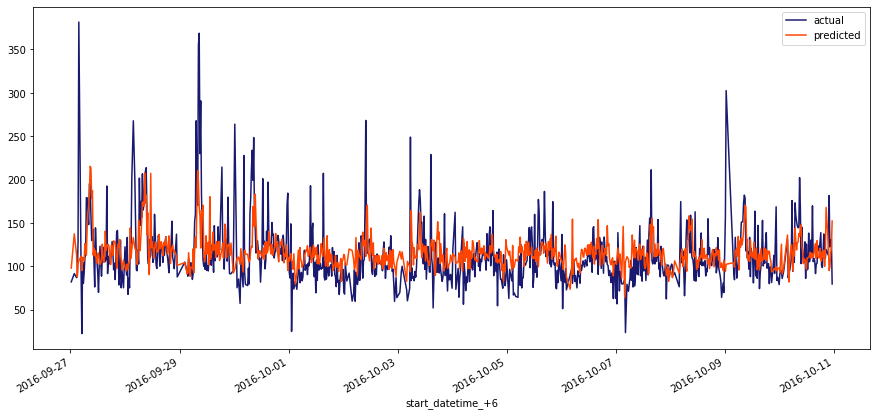

In [170]:
# base plot of true values
fig, ax = plt.subplots(figsize=(15,7))
base = A3_yval1.plot(ax=ax, color='midnightblue')

# overlay predicted values in red
A3_ypred_val_xgb1.plot(ax=base, color='orangered')

plt.legend(labels=['actual','predicted']);

### B1

In [171]:
B1_xtrain, B1_ytrain, B1_xval, B1_yval, B1_xtest, B1_ytest, B1_xtrain_columns, B1_ytrain_index, B1_yval_index, B1_ytest_index = df_route(train2, 'B1')

(2152, 27)
(718, 27)
(333, 27)
Index(['avg_travel_time', 'num_vehicles', 'num_vehicles_proportion',
       'day_of_week', 'weekday', 'holiday', 'rush_hour',
       'start_datetime_decimal', 'pressure', 'sea_pressure', 'wind_direction',
       'wind_speed', 'temperature', 'rel_humidity', 'precipitation',
       'hour_of_day2_[0, 4)', 'hour_of_day2_[4, 8)', 'hour_of_day2_[8, 12)',
       'hour_of_day2_[12, 16)', 'hour_of_day2_[16, 20)',
       'hour_of_day2_[20, 24)', 'avg_travel_time_+1', 'avg_travel_time_+2',
       'avg_travel_time_+3', 'avg_travel_time_+4', 'avg_travel_time_+5'],
      dtype='object')


#### XGBoost

In [172]:
%%time

# XGBoost
xgb = XGBRegressor(objective ='reg:squarederror', random_state=2020)

param_dist= {"n_estimators": randint(10,100), # no. of trees to build
             "learning_rate": uniform(0.001,0.2), # learning rate; step size shrinkage to prevent overfitting
             "max_depth": randint(10,100), # how deep each tree can grow
             "subsample": uniform(0.5,1), # range: (0,1], % samples used per tree; low value -> underfitting
             "colsample_bytree": uniform(0.5,1)} # range: (0,1], % samples used per tree; High value -> overfitting

# use RandomizedSearchCV for faster and effective performance
rs_xgb = RandomizedSearchCV(xgb, 
                            param_distributions=param_dist, 
                            n_iter=20,
                            scoring='neg_mean_squared_error',
                            cv=5,
                            n_jobs=-1, 
                            random_state=2020)

rs_xgb.fit(B1_xtrain, B1_ytrain)

# best params
print('Best Parameters: \n', rs_xgb.best_params_)

# Training MSE
print('Training MSE: ', abs(rs_xgb.best_score_))

Best Parameters: 
 {'colsample_bytree': 0.5200447598411051, 'learning_rate': 0.08343289041479898, 'max_depth': 16, 'n_estimators': 48, 'subsample': 0.6373567907977804}
Training MSE:  2847.600947814831
Wall time: 4.21 s


In [173]:
# XGBoost
# extract feature importances
feature_importances = pd.DataFrame(rs_xgb.best_estimator_.feature_importances_,
                                   index = B1_xtrain_columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
"hour_of_day2_[16, 20)",0.128500
precipitation,0.087805
"hour_of_day2_[8, 12)",0.079308
avg_travel_time_+3,0.072720
avg_travel_time_+4,0.050197


In [174]:
# XGBoost 
# best model from ensemble learning
best_xgb = rs_xgb.best_estimator_

# predict on validation set
B1_ypred_val_xgb = best_xgb.predict(B1_xval)

# Validation MSE
mse = mean_squared_error(B1_yval, B1_ypred_val_xgb)
print('Validation MSE: ', mse)

Validation MSE:  1661.6257377932002


In [175]:
# XGBoost
# Validation MAPE
B1_yval_mape = MAPE(B1_yval, B1_ypred_val_xgb)
print('Validation MAPE:', B1_yval_mape)

Validation MAPE: 0.2259258288437071


In [176]:
# XGBoost 
# predict on test set
B1_ypred_test_xgb = best_xgb.predict(B1_xtest)

# Test MSE
mse = mean_squared_error(B1_ytest, B1_ypred_test_xgb)
print('Test MSE: ', mse)

# Test MAPE
B1_ytest_mape = MAPE(B1_ytest, B1_ypred_test_xgb)
print('Test MAPE:', B1_ytest_mape)

Test MSE:  3145.2895777345407
Test MAPE: 0.23273984695528396


In [177]:
# convert prediction array to df
B1_ypred_val_xgb1 = pd.DataFrame(B1_ypred_val_xgb)
B1_ypred_val_xgb1.index = B1_yval_index

In [178]:
# convert true validation array to df
B1_yval1 = pd.DataFrame(B1_yval)
B1_yval1.index = B1_yval_index

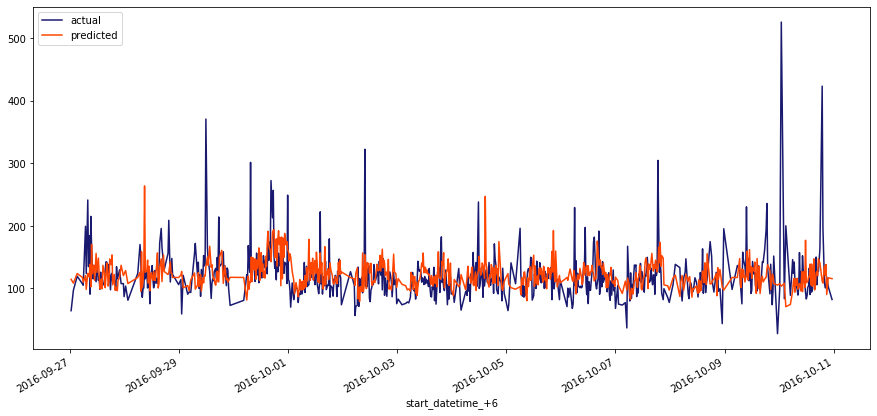

In [179]:
# base plot of true values
fig, ax = plt.subplots(figsize=(15,7))
base = B1_yval1.plot(ax=ax, color='midnightblue')

# overlay predicted values in red
B1_ypred_val_xgb1.plot(ax=base, color='orangered')

plt.legend(labels=['actual','predicted']);

### B3

In [180]:
B3_xtrain, B3_ytrain, B3_xval, B3_yval, B3_xtest, B3_ytest, B3_xtrain_columns, B3_ytrain_index, B3_yval_index, B3_ytest_index = df_route(train2, 'B3')

(3606, 27)
(815, 27)
(379, 27)
Index(['avg_travel_time', 'num_vehicles', 'num_vehicles_proportion',
       'day_of_week', 'weekday', 'holiday', 'rush_hour',
       'start_datetime_decimal', 'pressure', 'sea_pressure', 'wind_direction',
       'wind_speed', 'temperature', 'rel_humidity', 'precipitation',
       'hour_of_day2_[0, 4)', 'hour_of_day2_[4, 8)', 'hour_of_day2_[8, 12)',
       'hour_of_day2_[12, 16)', 'hour_of_day2_[16, 20)',
       'hour_of_day2_[20, 24)', 'avg_travel_time_+1', 'avg_travel_time_+2',
       'avg_travel_time_+3', 'avg_travel_time_+4', 'avg_travel_time_+5'],
      dtype='object')


#### XGBoost

In [181]:
%%time

# XGBoost
xgb = XGBRegressor(objective ='reg:squarederror', random_state=2020)

param_dist= {"n_estimators": randint(10,100), # no. of trees to build
             "learning_rate": uniform(0.001,0.2), # learning rate; step size shrinkage to prevent overfitting
             "max_depth": randint(10,100), # how deep each tree can grow
             "subsample": uniform(0.5,1), # range: (0,1], % samples used per tree; low value -> underfitting
             "colsample_bytree": uniform(0.5,1)} # range: (0,1], % samples used per tree; High value -> overfitting

# use RandomizedSearchCV for faster and effective performance
rs_xgb = RandomizedSearchCV(xgb, 
                            param_distributions=param_dist, 
                            n_iter=20,
                            scoring='neg_mean_squared_error',
                            cv=5,
                            n_jobs=-1, 
                            random_state=2020)

rs_xgb.fit(B3_xtrain, B3_ytrain)

# best params
print('Best Parameters: \n', rs_xgb.best_params_)

# Training MSE
print('Training MSE: ', abs(rs_xgb.best_score_))

Best Parameters: 
 {'colsample_bytree': 0.5200447598411051, 'learning_rate': 0.08343289041479898, 'max_depth': 16, 'n_estimators': 48, 'subsample': 0.6373567907977804}
Training MSE:  1764.2679539705787
Wall time: 8.73 s


In [182]:
# XGBoost
# extract feature importances
feature_importances = pd.DataFrame(rs_xgb.best_estimator_.feature_importances_,
                                   index = B3_xtrain_columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
"hour_of_day2_[4, 8)",0.083131
precipitation,0.075626
"hour_of_day2_[12, 16)",0.065104
avg_travel_time_+5,0.054853
avg_travel_time_+3,0.054216


In [183]:
# XGBoost 
# best model from ensemble learning
best_xgb = rs_xgb.best_estimator_

# predict on validation set
B3_ypred_val_xgb = best_xgb.predict(B3_xval)

# Validation MSE
mse = mean_squared_error(B3_yval, B3_ypred_val_xgb)
print('Validation MSE: ', mse)

Validation MSE:  3503.644119882372


In [184]:
# XGBoost
# Validation MAPE
B3_yval_mape = MAPE(B3_yval, B3_ypred_val_xgb)
print('Validation MAPE:', B3_yval_mape)

Validation MAPE: 0.2517261136117325


In [185]:
# XGBoost 
# predict on test set
B3_ypred_test_xgb = best_xgb.predict(B3_xtest)

# Test MSE
mse = mean_squared_error(B3_ytest, B3_ypred_test_xgb)
print('Test MSE: ', mse)

# Test MAPE
B3_ytest_mape = MAPE(B3_ytest, B3_ypred_test_xgb)
print('Test MAPE:', B3_ytest_mape)

Test MSE:  926.7179437835829
Test MAPE: 0.2707516273801443


In [186]:
# convert prediction array to df
B3_ypred_val_xgb1 = pd.DataFrame(B3_ypred_val_xgb)
B3_ypred_val_xgb1.index = B3_yval_index

In [187]:
# convert true validation array to df
B3_yval1 = pd.DataFrame(B3_yval)
B3_yval1.index = B3_yval_index

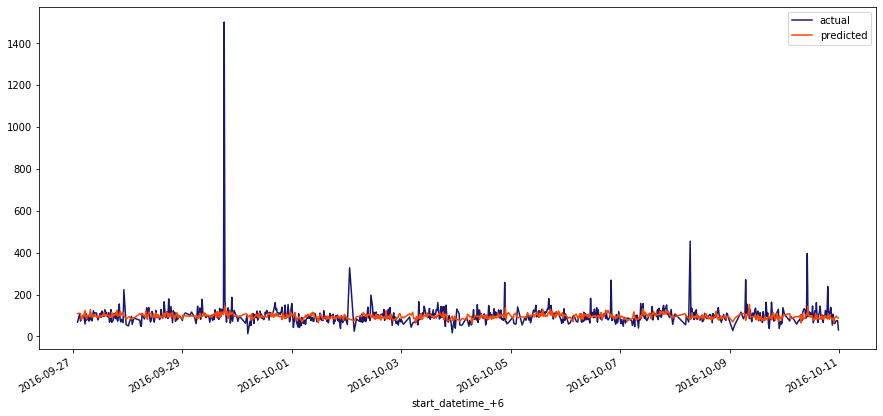

In [188]:
# base plot of true values
fig, ax = plt.subplots(figsize=(15,7))
base = B3_yval1.plot(ax=ax, color='midnightblue')

# overlay predicted values in red
B3_ypred_val_xgb1.plot(ax=base, color='orangered')

plt.legend(labels=['actual','predicted']);

### C1

In [189]:
C1_xtrain, C1_ytrain, C1_xval, C1_yval, C1_xtest, C1_ytest, C1_xtrain_columns, C1_ytrain_index, C1_yval_index, C1_ytest_index = df_route(train2, 'C1')

(2241, 27)
(709, 27)
(338, 27)
Index(['avg_travel_time', 'num_vehicles', 'num_vehicles_proportion',
       'day_of_week', 'weekday', 'holiday', 'rush_hour',
       'start_datetime_decimal', 'pressure', 'sea_pressure', 'wind_direction',
       'wind_speed', 'temperature', 'rel_humidity', 'precipitation',
       'hour_of_day2_[0, 4)', 'hour_of_day2_[4, 8)', 'hour_of_day2_[8, 12)',
       'hour_of_day2_[12, 16)', 'hour_of_day2_[16, 20)',
       'hour_of_day2_[20, 24)', 'avg_travel_time_+1', 'avg_travel_time_+2',
       'avg_travel_time_+3', 'avg_travel_time_+4', 'avg_travel_time_+5'],
      dtype='object')


#### XGBoost

In [190]:
%%time

# XGBoost
xgb = XGBRegressor(objective ='reg:squarederror', random_state=2020)

param_dist= {"n_estimators": randint(10,100), # no. of trees to build
             "learning_rate": uniform(0.001,0.2), # learning rate; step size shrinkage to prevent overfitting
             "max_depth": randint(10,100), # how deep each tree can grow
             "subsample": uniform(0.5,1), # range: (0,1], % samples used per tree; low value -> underfitting
             "colsample_bytree": uniform(0.5,1)} # range: (0,1], % samples used per tree; High value -> overfitting

# use RandomizedSearchCV for faster and effective performance
rs_xgb = RandomizedSearchCV(xgb, 
                            param_distributions=param_dist, 
                            n_iter=20,
                            scoring='neg_mean_squared_error',
                            cv=5,
                            n_jobs=-1, 
                            random_state=2020)

rs_xgb.fit(C1_xtrain, C1_ytrain)

# best params
print('Best Parameters: \n', rs_xgb.best_params_)

# Training MSE
print('Training MSE: ', abs(rs_xgb.best_score_))

Best Parameters: 
 {'colsample_bytree': 0.5200447598411051, 'learning_rate': 0.08343289041479898, 'max_depth': 16, 'n_estimators': 48, 'subsample': 0.6373567907977804}
Training MSE:  4801.033472014821
Wall time: 4.73 s


In [191]:
# XGBoost
# extract feature importances
feature_importances = pd.DataFrame(rs_xgb.best_estimator_.feature_importances_,
                                   index = C1_xtrain_columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
precipitation,0.209641
"hour_of_day2_[16, 20)",0.154368
avg_travel_time_+5,0.095254
rel_humidity,0.048679
"hour_of_day2_[8, 12)",0.047926


In [192]:
# XGBoost 
# best model from ensemble learning
best_xgb = rs_xgb.best_estimator_

# predict on validation set
C1_ypred_val_xgb = best_xgb.predict(C1_xval)

# Validation MSE
mse = mean_squared_error(C1_yval, C1_ypred_val_xgb)
print('Validation MSE: ', mse)

Validation MSE:  3645.5065499912685


In [193]:
# XGBoost
# Validation MAPE
C1_yval_mape = MAPE(C1_yval, C1_ypred_val_xgb)
print('Validation MAPE:', C1_yval_mape)

Validation MAPE: 0.2165711221962377


In [194]:
# XGBoost 
# predict on test set
C1_ypred_test_xgb = best_xgb.predict(C1_xtest)

# Test MSE
mse = mean_squared_error(C1_ytest, C1_ypred_test_xgb)
print('Test MSE: ', mse)

# Test MAPE
C1_ytest_mape = MAPE(C1_ytest, C1_ypred_test_xgb)
print('Test MAPE:', C1_ytest_mape)

Test MSE:  2541.3016717041814
Test MAPE: 0.18890515410378794


In [195]:
# convert prediction array to df
C1_ypred_val_xgb1 = pd.DataFrame(C1_ypred_val_xgb)
C1_ypred_val_xgb1.index = C1_yval_index

In [196]:
# convert true validation array to df
C1_yval1 = pd.DataFrame(C1_yval)
C1_yval1.index = C1_yval_index

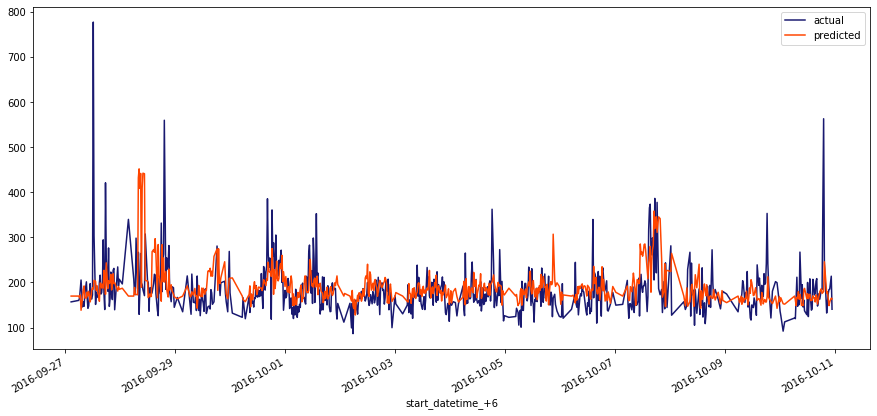

In [197]:
# base plot of true values
fig, ax = plt.subplots(figsize=(15,7))
base = C1_yval1.plot(ax=ax, color='midnightblue')

# overlay predicted values in red
C1_ypred_val_xgb1.plot(ax=base, color='orangered')

plt.legend(labels=['actual','predicted']);

### C3

In [198]:
C3_xtrain, C3_ytrain, C3_xval, C3_yval, C3_xtest, C3_ytest, C3_xtrain_columns, C3_ytrain_index, C3_yval_index, C3_ytest_index = df_route(train2, 'C3')

(1803, 27)
(531, 27)
(241, 27)
Index(['avg_travel_time', 'num_vehicles', 'num_vehicles_proportion',
       'day_of_week', 'weekday', 'holiday', 'rush_hour',
       'start_datetime_decimal', 'pressure', 'sea_pressure', 'wind_direction',
       'wind_speed', 'temperature', 'rel_humidity', 'precipitation',
       'hour_of_day2_[0, 4)', 'hour_of_day2_[4, 8)', 'hour_of_day2_[8, 12)',
       'hour_of_day2_[12, 16)', 'hour_of_day2_[16, 20)',
       'hour_of_day2_[20, 24)', 'avg_travel_time_+1', 'avg_travel_time_+2',
       'avg_travel_time_+3', 'avg_travel_time_+4', 'avg_travel_time_+5'],
      dtype='object')


#### XGBoost

In [199]:
%%time

# XGBoost
xgb = XGBRegressor(objective ='reg:squarederror', random_state=2020)

param_dist= {"n_estimators": randint(10,100), # no. of trees to build
             "learning_rate": uniform(0.001,0.2), # learning rate; step size shrinkage to prevent overfitting
             "max_depth": randint(10,100), # how deep each tree can grow
             "subsample": uniform(0.5,1), # range: (0,1], % samples used per tree; low value -> underfitting
             "colsample_bytree": uniform(0.5,1)} # range: (0,1], % samples used per tree; High value -> overfitting

# use RandomizedSearchCV for faster and effective performance
rs_xgb = RandomizedSearchCV(xgb, 
                            param_distributions=param_dist, 
                            n_iter=20,
                            scoring='neg_mean_squared_error',
                            cv=5,
                            n_jobs=-1, 
                            random_state=2020)

rs_xgb.fit(C3_xtrain, C3_ytrain)

# best params
print('Best Parameters: \n', rs_xgb.best_params_)

# Training MSE
print('Training MSE: ', abs(rs_xgb.best_score_))

Best Parameters: 
 {'colsample_bytree': 0.5200447598411051, 'learning_rate': 0.08343289041479898, 'max_depth': 16, 'n_estimators': 48, 'subsample': 0.6373567907977804}
Training MSE:  5579.507002923032
Wall time: 3.35 s


In [200]:
# XGBoost
# extract feature importances
feature_importances = pd.DataFrame(rs_xgb.best_estimator_.feature_importances_,
                                   index = C3_xtrain_columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
"hour_of_day2_[16, 20)",0.164598
precipitation,0.137533
rush_hour,0.093562
avg_travel_time_+5,0.048778
"hour_of_day2_[8, 12)",0.045602


In [201]:
# XGBoost 
# best model from ensemble learning
best_xgb = rs_xgb.best_estimator_

# predict on validation set
C3_ypred_val_xgb = best_xgb.predict(C3_xval)

# Validation MSE
mse = mean_squared_error(C3_yval, C3_ypred_val_xgb)
print('Validation MSE: ', mse)

Validation MSE:  3676.9800490013176


In [202]:
# XGBoost
# Validation MAPE
C3_yval_mape = MAPE(C3_yval, C3_ypred_val_xgb)
print('Validation MAPE:', C3_yval_mape)

Validation MAPE: 0.2670193658917798


In [203]:
# XGBoost 
# predict on test set
C3_ypred_test_xgb = best_xgb.predict(C3_xtest)

# Test MSE
mse = mean_squared_error(C3_ytest, C3_ypred_test_xgb)
print('Test MSE: ', mse)

# Test MAPE
C3_ytest_mape = MAPE(C3_ytest, C3_ypred_test_xgb)
print('Test MAPE:', C3_ytest_mape)

Test MSE:  3908.6614236802634
Test MAPE: 0.25604569255023546


In [204]:
# convert prediction array to df
C3_ypred_val_xgb1 = pd.DataFrame(C3_ypred_val_xgb)
C3_ypred_val_xgb1.index = C3_yval_index

In [205]:
# convert true validation array to df
C3_yval1 = pd.DataFrame(C3_yval)
C3_yval1.index = C3_yval_index

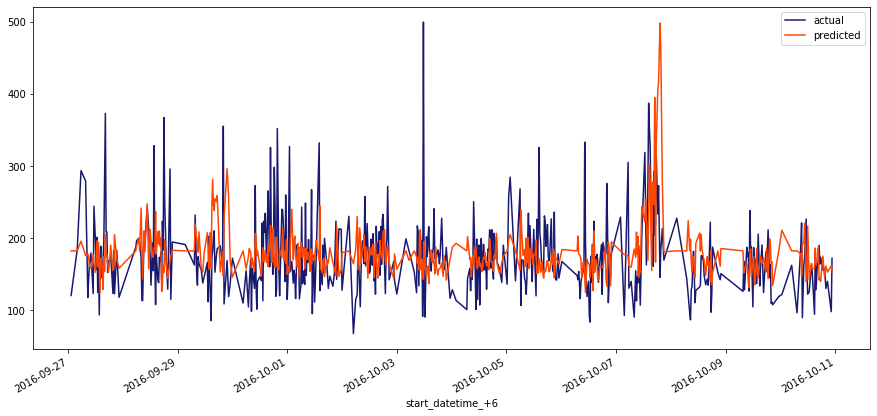

In [206]:
# base plot of true values
fig, ax = plt.subplots(figsize=(15,7))
base = C3_yval1.plot(ax=ax, color='midnightblue')

# overlay predicted values in red
C3_ypred_val_xgb1.plot(ax=base, color='orangered')

plt.legend(labels=['actual','predicted']);

### Overall Evaluation

#### Validation set

In [207]:
print(A2_yval_mape, A3_yval_mape, B1_yval_mape, B3_yval_mape, C1_yval_mape, C3_yval_mape)

0.25093264699131607 0.2169023911302412 0.2259258288437071 0.2517261136117325 0.2165711221962377 0.2670193658917798


In [208]:
overall_mape = np.mean([A2_yval_mape, A3_yval_mape, B1_yval_mape, B3_yval_mape, C1_yval_mape, C3_yval_mape])
overall_mape

0.23817957811083576

#### Test set

In [209]:
print(A2_ytest_mape, A3_ytest_mape, B1_ytest_mape, B3_ytest_mape, C1_ytest_mape, C3_ytest_mape)

0.23481697735031876 0.22717501472091134 0.23273984695528396 0.2707516273801443 0.18890515410378794 0.25604569255023546


In [210]:
overall_mape = np.mean([A2_ytest_mape, A3_ytest_mape, B1_ytest_mape, B3_ytest_mape, C1_ytest_mape, C3_ytest_mape])
overall_mape

0.23507238551011359

In [211]:
A2_ytest[datetime(2016,10,11,8,0,0):datetime(2016,10,11,9,40,0)]

start_datetime_+6
2016-10-11 08:00:00    68.09
2016-10-11 08:20:00    75.02
2016-10-11 08:40:00    75.00
2016-10-11 09:00:00    69.75
2016-10-11 09:20:00    55.28
2016-10-11 09:40:00    70.26
Name: avg_travel_time_+6, dtype: float64

In [215]:
# convert prediction array to df
A2_ypred_test_xgb1 = pd.DataFrame(A2_ypred_test_xgb)
A2_ypred_test_xgb1.index = A2_ytest_index

In [216]:
A2_ypred_test_xgb1[datetime(2016,10,11,8,0,0):datetime(2016,10,11,9,40,0)]

,0
start_datetime_+6,
2016-10-11 08:00:00,76.931618
2016-10-11 08:20:00,65.579430
2016-10-11 08:40:00,67.036835
2016-10-11 09:00:00,71.163719
2016-10-11 09:20:00,77.732880
2016-10-11 09:40:00,65.642502
